# The Laplace Problem

In [14]:
%reset -f

In [15]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

import numpy as np
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')           ## CPU is faster here !

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='ticks',
        font='sans-serif', font_scale=1, color_codes=True, rc={"lines.linewidth": 2})

from updec import *
# from updec.cloud import SquareCloud, GmshCloud
# from updec.operators import *
# from updec.utils import print_line_by_line, polyharmonic, multiquadric

## Using Updec

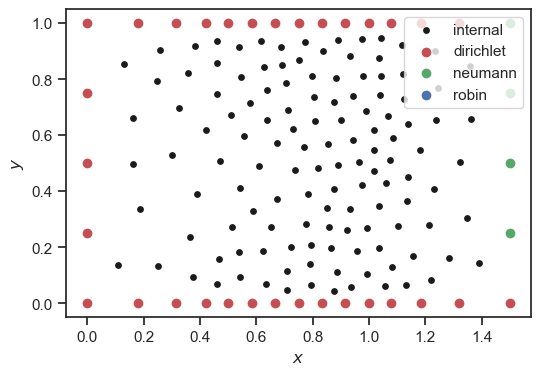

In [16]:
# facet_types = {"south":"d", "west":"d", "north":"d", "east":"d"}
# facet_types = {"Dirichlet":"d", "Robin":"d", "Neumann":"d"}
facet_types = {"inlet":"d", "wall":"d", "blowing":"d", "outlet":"n", "suction":"d"}

# cloud = SquareCloud(Nx=7, Ny=5, facet_types=facet_types, support_size=3)
# cloud = GmshCloud("./meshes/triangle.msh", facet_types, support_size=3)
cloud = GmshCloud("./meshes/channel.msh", facet_types, support_size=20)

cloud.visualize_cloud(figsize=(6,4));

In [17]:
RBF = polyharmonic      ## Can define which rbf to use
MAX_DEGREE = 4

In [18]:
# ## Operates on radial basis functions and polynomials at position x: don't forget the None. It is important!
# # @jax.jit
# # @partial(jax.jit, static_argnums=2)
# def my_diff_operator(x, node=None, monomial=None, *args):
#     return  args[0] * nodal_laplacian(x, node, monomial, rbf=RBF) / args[1]

# minus_ones = -jnp.ones((cloud.N,))
# ones = jnp.ones((cloud.N,))
# ## Operates on entire fields at position x (inside node)
# # @jax.jit
# def my_rhs_operator(x):
#     # return divergence(x, known_field, cloud, rbf=RBF, max_degree=2)
#     # return 2.0
#     return 1.0

# d_north = lambda node: jnp.sin(jnp.pi * node[0])
# d_zero = lambda node: 0.0

# # boundary_conditions = {0:d_zero, 1:d_zero, 2:d_zero, 3:d_zero}
# boundary_conditions = {"inlet":d_north, "wall":d_zero, "blowing":d_zero, "outlet":d_zero, "suction":d_zero}

# # solution_field = pde_solver(my_diff_operator, my_rhs_operator, cloud, boundary_conditions, RBF, MAX_DEGREE, minus_ones, ones)
# # cloud.visualize_field(solution_field, cmap="viridis", projection="2d", ax=None, figsize=(6,5));

In [19]:
d_north = lambda node: jnp.sin(jnp.pi * node[0])
d_zero = lambda node: 0.0

boundary_conditions = {"inlet":d_north, "wall":d_zero, "blowing":d_zero, "outlet":d_zero, "suction":d_zero}

In [20]:
u = jnp.ones((cloud.N,))
v = jnp.ones((cloud.N,))
p = jnp.ones((cloud.N,))
RHO = 1
NU = 1

def diff_operator_u(x, node=None, monomial=None, *args):
    u_val = nodal_value(x, node, monomial, rbf=RBF)
    grad_u = nodal_gradient(x, node, monomial, rbf=RBF)
    return  u_val * grad_u[0] + args[0]*grad_u[1]           ## TODO: Actually, this is wrong. write this nodal fomrula down !

def rhs_operator_u(x):
    grad_p = gradient(x, p, cloud, rbf=RBF, max_degree=MAX_DEGREE)
    lap_u = laplacian(x, u, cloud, rbf=RBF, max_degree=MAX_DEGREE)
    return  (-grad_p[0] / RHO) + (NU * lap_u)

u = pde_solver(diff_operator_u, rhs_operator_u, cloud, boundary_conditions, RBF, MAX_DEGREE, v)

In [21]:
u

DeviceArray([ 1.25602812e+04, -6.60766000e+05,  6.74500859e+04,
              2.65863359e+04,  1.39744797e+05,  3.04787930e+04,
              3.13519043e+04, -3.20297688e+05, -9.81947266e+04,
             -7.80720234e+04,  2.58428453e+05,  3.20374250e+05,
              5.80308750e+04,  1.53738531e+05,  1.00061273e+05,
             -1.17959406e+05, -2.70849707e+04,  1.62652984e+05,
             -4.21520273e+04,  7.31308047e+04,  1.29665445e+05,
             -2.00960703e+05,  2.65075125e+05,  5.19772719e+05,
              1.27602031e+05,  7.26812375e+05,  8.25745438e+05,
             -1.23854297e+04,  1.13811317e+02, -4.24638750e+04,
             -3.38888125e+04, -2.02681656e+05, -5.98378688e+05,
              6.02427695e+04, -4.44875156e+05, -5.11404609e+04,
             -2.18506738e+03, -1.83152754e+04, -1.54988312e+05,
             -1.13613891e+05, -1.30531039e+05,  3.95015195e+04,
             -2.75264648e+04, -7.36461523e+03,  1.29891797e+04,
              3.45518125e+05, -9.0745287

In [22]:
# def diff_operator_v(x, node=None, monomial=None, *args):
#     val_v = nodal_value(x, node, monomial, rbf=RBF)
#     grad_v = nodal_gradient(x, node, monomial, rbf=RBF)
#     return  val_v * grad_v[1] + args[0]*grad_v[0]

# def rhs_operator_v(x):
#     grad_p = gradient(x, p, cloud, rbf=RBF, max_degree=MAX_DEGREE)
#     lap_v = laplacian(x, v, cloud, rbf=RBF, max_degree=MAX_DEGREE)
#     return  (-grad_p[0] / RHO) + (NU * lap_v)

# v = pde_solver(diff_operator_v, rhs_operator_v, cloud, boundary_conditions, RBF, MAX_DEGREE, u)

In [23]:
# def diff_operator_p(x, node=None, monomial=None, *args):
#     return  nodal_laplacian(x, node, monomial, rbf=RBF)

# def rhs_operator_p(x):
#     grad_u = gradient(x, u, cloud, rbf=RBF, max_degree=MAX_DEGREE)
#     grad_v = gradient(x, v, cloud, rbf=RBF, max_degree=MAX_DEGREE)
#     return  -RHO * (grad_u[0]*grad_u[0] + 2*grad_u[1]*grad_v[0] + grad_v[1]*grad_v[1])

# p = pde_solver(diff_operator_p, rhs_operator_p, cloud, boundary_conditions, RBF, MAX_DEGREE)

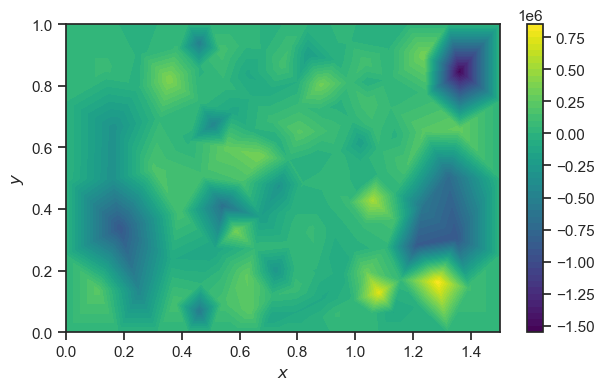

In [24]:
cloud.visualize_field(u, cmap="viridis", projection="2d", ax=None, figsize=(7,4));